**Task**<br>
Build an algorithm for classification of user reviews in to one of the four categories. The quality of the algorithm should be evaluated using hold-out subset or cross-validation technique.

# Import Libraries

In [ ]:
from google.colab import drive, files

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#Text preprocessing
import re
import string

#Sklearn models/utilities
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score, plot_confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

#Method to save models
import pickle

#Tokenizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#Upsampling method
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

#Gradient boosting model
import lightgbm as lgb
from lightgbm import LGBMClassifier

#Keras libraries 
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

#Nltk for Keras custom embeddings
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

#Method to save best Keras models
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

#Used to unzip GloVe embeddings file
import zipfile

#Keras vectorizer for GloVe embeddings
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf

#Tensorflow embedding layer for Keras model
from tensorflow.keras.layers import Embedding
from tensorflow import keras

#All layers for Keras model
from tensorflow.keras import layers

#Method to balance the class weights for Keras
from sklearn.utils import class_weight

#Additional libraries for Keras BERT(tensorflow and tensorflow.keras needed)
!pip install bert-for-tf2
import tensorflow_hub as hub
from bert import bert_tokenization

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 51kB 4.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=b6bd4ee4d1570445b01bb5c17a71ab66dc575124747b010772c15da965113a4f
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=40382c39a79fe6890aae390ae96e66931341891eb74de0a49092088003bcec71
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=c089078a632c29e996086294daf1bdc5fd7fcf586d4ad1bb1793799dfce38379
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-pa

# Load Data

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/My Drive'

 bert_features-2.npz				 reviews.xlsx
 bert_features.npz				 spacy_features_basic.npz
'Colab Notebooks'				 spacy_features_lemma-2.npz
 keras_glove_92acc_70macrof1			 spacy_features_lemma.npz
 keras_glove_92acc_70macrof1_alt_preprocessing	 spacy_features.npz
 lgbm_model.npz					 spacy_train.gdoc
 lgbm_model.sav					 spacy_train.txt
'Misc Junk'					 test.txt
 model.h5


In [ ]:
df = pd.read_excel('/content/gdrive/My Drive/reviews.xlsx')

In [ ]:
df

,id,mark,review
0,6720,RL,"It's not Turkish, it's a lie, but I recommend ..."
1,43313,RL,You don't have Korean
2,26549,RL,"Very nice, only if it were in Italian it would..."
3,42306,RL,The game is nice but when it comes to Turkish ...
4,32331,RL,"Amazing work, hope to achieve 100% Chinese tra..."
...,...,...,...
51795,10863,RL,The game is very nice and fun but without Viet...
51796,7444,RL,It's cool but it's in English
51797,14647,RL,"When I enter, but a game, an advertisement is ..."
51798,15369,RL,The Turkish language is required and the task ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51800 entries, 0 to 51799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51800 non-null  int64 
 1   mark    51800 non-null  object
 2   review  51800 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


## Preprocessing

In [ ]:
#Check unique values in mark column
df['mark'].value_counts()

RL    42684
L-     5474
YL     2961
L+      666
Rl       10
l-        3
Yl        1
yl        1
Name: mark, dtype: int64

In [ ]:
#Standardize mark column
df['mark'] = df['mark'].str.lower()

In [ ]:
df['mark'].value_counts()

rl    42694
l-     5477
yl     2963
l+      666
Name: mark, dtype: int64

In [ ]:
#Check for duplicates
df.duplicated().sum()

0

In [ ]:
df_bert_model = df.copy()

In [ ]:
#Function to remove unnecessary characters
def clear_text(text):
    
    text = re.sub(r"[^a-zA-Z']", ' ', text.lower()) 
    return ' '.join(text.split())

In [ ]:
#Alternate function to clean the text
def clean_text(text):
  '''Make text lowercase, remove text in square brackets,
  remove \n,remove punctuation and remove words containing numbers.'''
  text = str(text).lower()
  text = re.sub("<.*?>+", '', text)
  text = re.sub("[%s]" % re.escape(string.punctuation), '', text)
  text = re.sub("\n", '', text)
  text = re.sub("\w*\d\w*", '', text)
  return text

In [ ]:
df['review'].iloc[0]

"It's not Turkish, it's a lie, but I recommend it well"

In [ ]:
#Apply one of the above functions to the text
#df['review'] = df['review'].apply(clear_text)
df['review'] = df['review'].apply(clean_text)

In [ ]:
#See what the function has done to the review column
df['review'].iloc[0]

'its not turkish its a lie but i recommend it well'

In [ ]:
#Check short reviews
df[df.review.str.len() <4]

,id,mark,review
968,6284,rl,
2778,45703,rl,
3904,26208,rl,plz
6538,1037,rl,
8779,47782,yl,👍👍👍
13292,12229,rl,😕😕😕
14029,47768,rl,
23782,43514,rl,🙏🏽
24301,7550,rl,pls
31569,42740,rl,now


In [ ]:
df = df[df['review'].str.len() >4]
df_bert_model = df_bert_model[df_bert_model['review'].str.len() >4]

In [ ]:
df[df['review'].astype('str').apply(len)>15000]

,id,mark,review
8811,43270,l-,iratus lord of the dead is a turnbased rogueli...
46078,50626,l-,thats one points i bought it because of its ...
46204,39529,l-,its just one points i bought it because of i...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51782 entries, 0 to 51799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51782 non-null  int64 
 1   mark    51782 non-null  object
 2   review  51782 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


# EDA

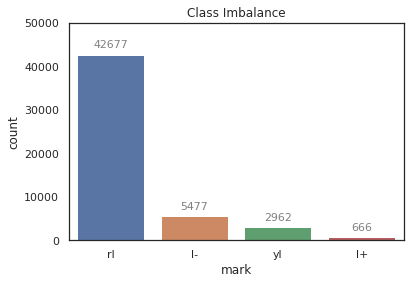

In [ ]:
#Graph for class imbalance
sns.set_theme(style='white')
plot = sns.countplot(x=df['mark'], data=df, order=df['mark'].value_counts().index)
ax = plot
plt.title("Class Imbalance")
plt.yticks(rotation=0)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
plt.ylim(0, 50000)
plt.show();
fig = ax.get_figure()
fig.savefig("ClassImbalanceCountPlot.png")

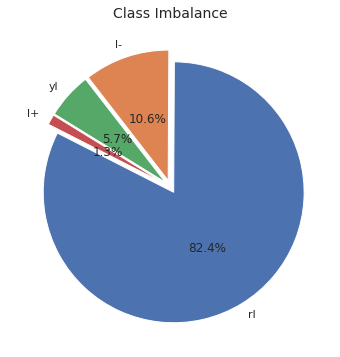

In [ ]:
#Using matplotlib
pie, ax = plt.subplots(figsize=[10,6])
labels = df['mark'].value_counts().index
sns.color_palette('bright')
plt.pie(x=df['mark'].value_counts(), autopct="%.1f%%",
        explode=[0.05]*4, labels=labels, pctdistance=0.5, startangle=153,
        counterclock=True)
plt.title("Class Imbalance", fontsize=14);
pie.savefig("ClassImbalancePieChart.png")

In [ ]:
df['mark'].value_counts()

rl    42677
l-     5477
yl     2962
l+      666
Name: mark, dtype: int64

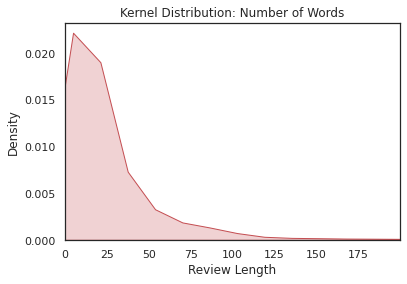

<Figure size 864x432 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
plt.figure(figsize=(12,6))
kdeplot = sns.kdeplot(df['review'].apply(lambda x: len(x.split())),
               shade=True,
               color='r',
               ax=ax
               ).set_title('Kernel Distribution: Number of Words')
ax.set_xlim(0, 200)
ax.set_xticks(range(0,200,25))
ax.set_xlabel('Review Length')
plt.show();
fig = kdeplot.get_figure()
fig.savefig("KernelDist_NumberOfWords.png")

In [ ]:
cloud_df = df.copy()

In [ ]:
# Clean text
text = clean_text(cloud_df['review'])

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

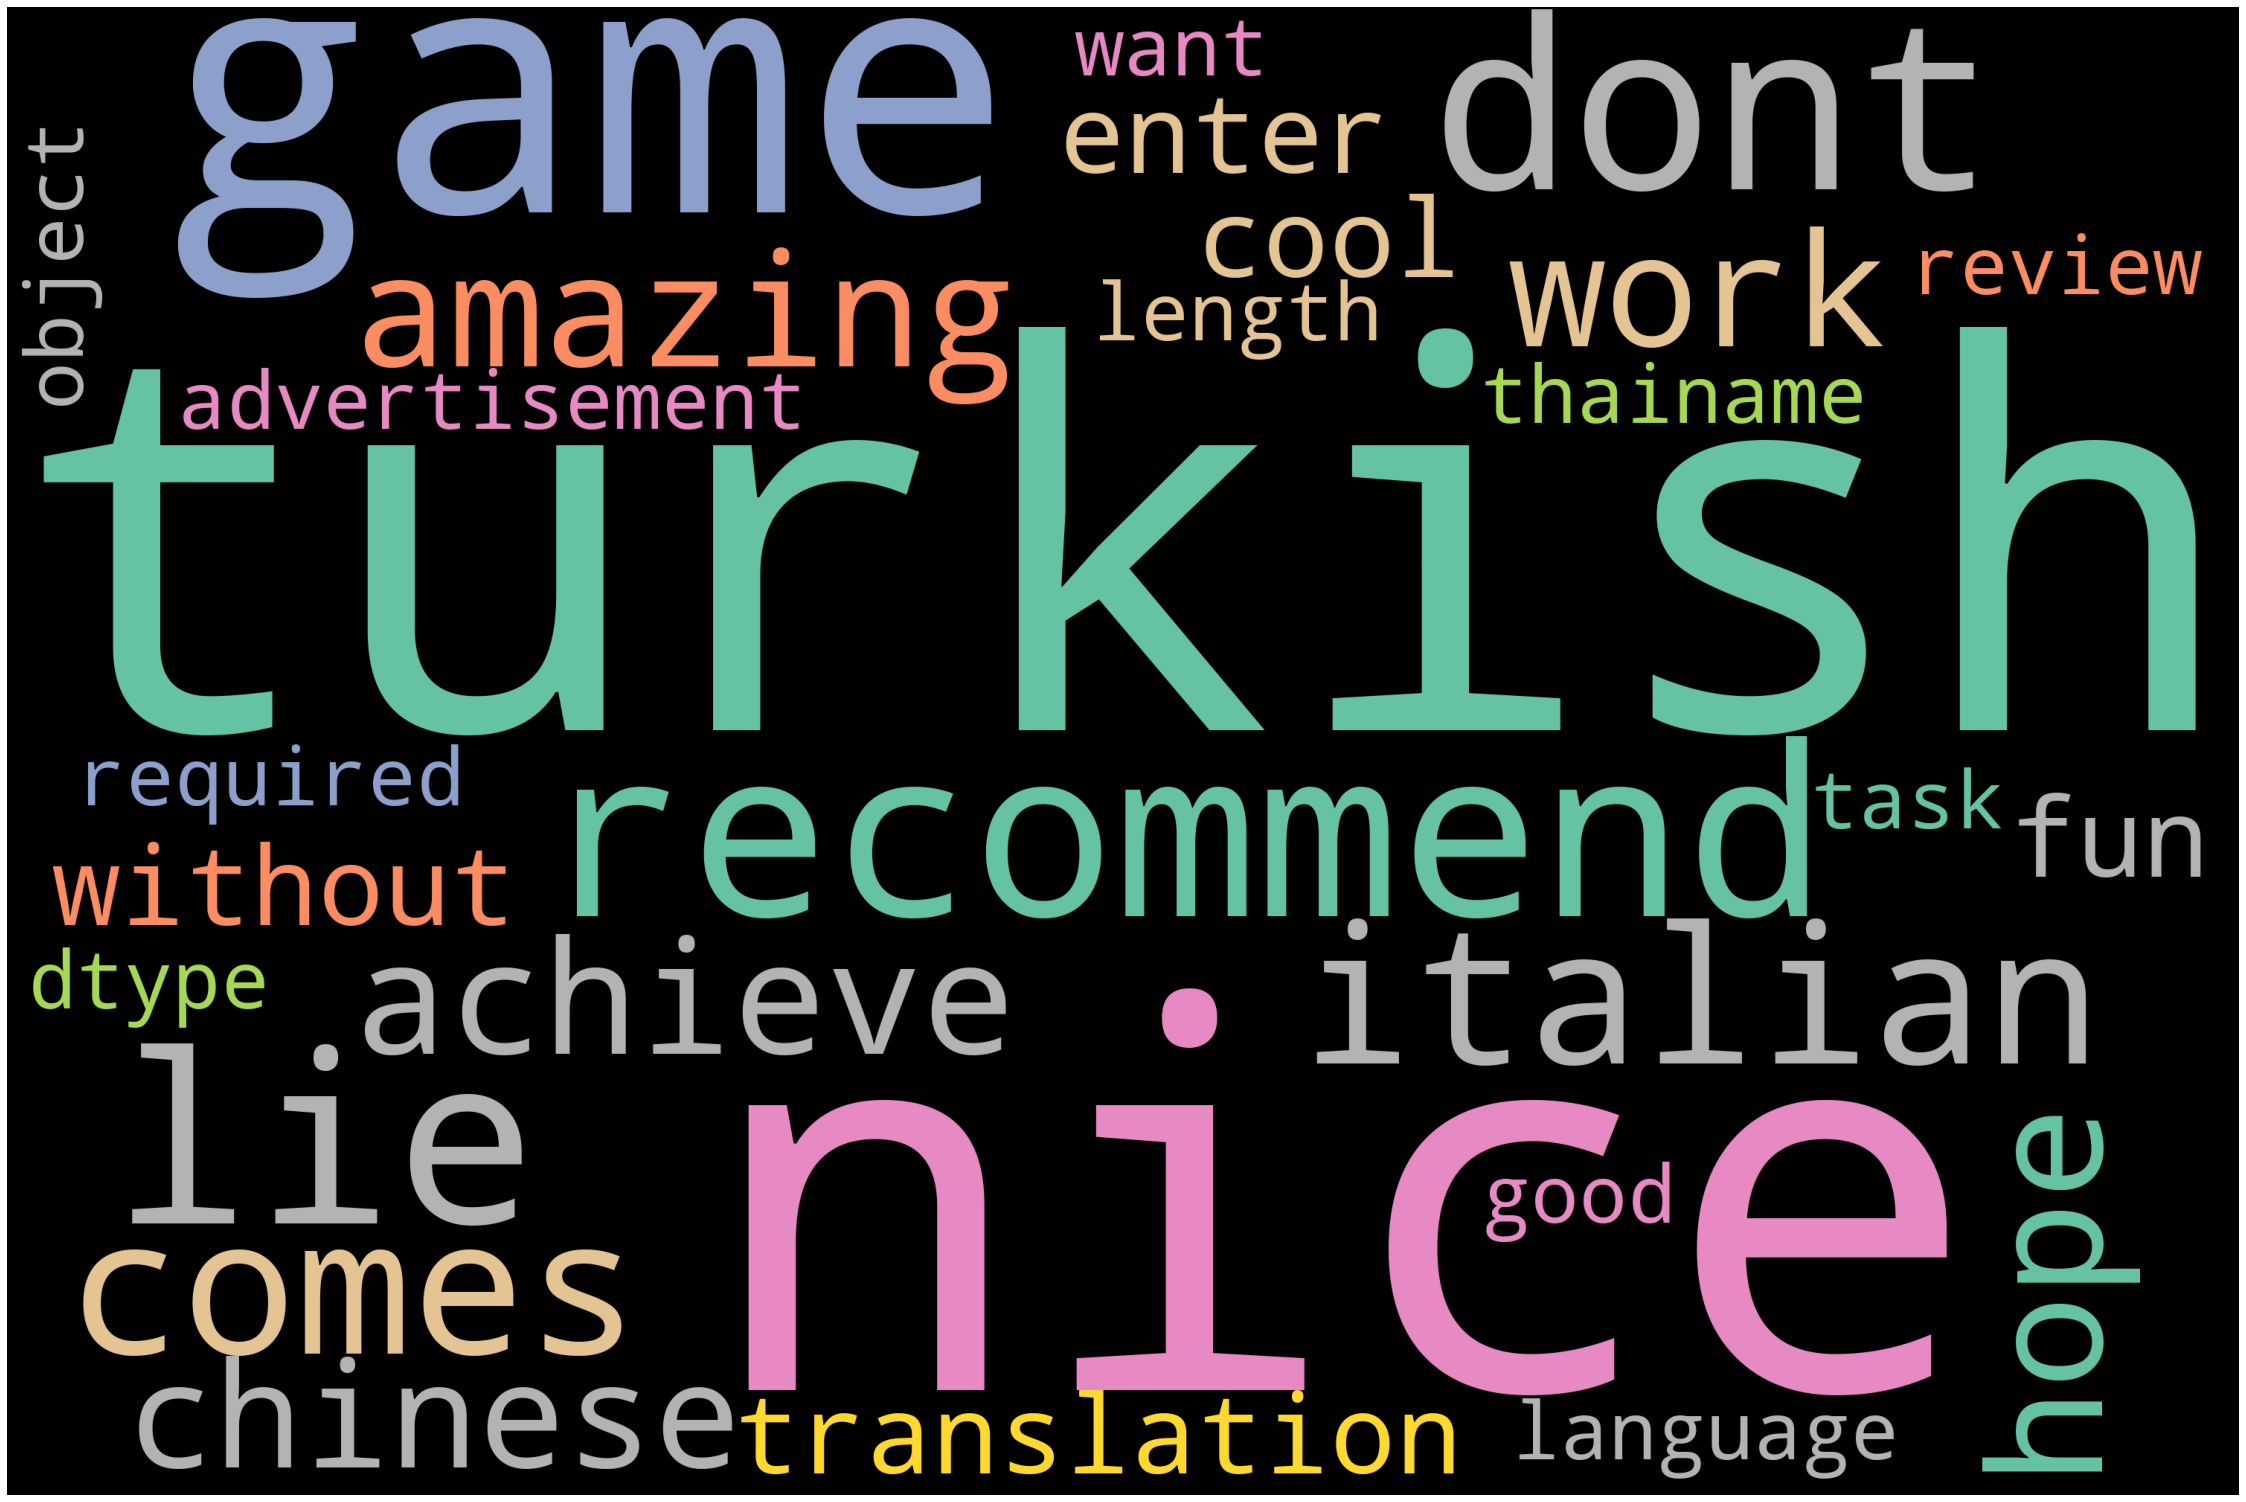

In [ ]:
# Generate wordcloud
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      random_state=1,
                      background_color='black',
                      colormap='Set2',
                      collocations=False,
                      stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)
wordcloud.to_file('wordcloud.png')

# Models

In [ ]:
#Set features and target variables
features = df['review']
target = df['mark']

In [ ]:
#Make a copy of the df with unnecessary characters removed
df_bert_model_2 = df.copy()

In [ ]:
'''Plot a confusion matrix and classification report using the model,
 test features, and test target'''
def evaluation_metric(model, features_test, target_test):
  plot_confusion_matrix(model, features_test, target_test, values_format='')
  plt.show()

  print(classification_report(target_test, model.predict(features_test)))

## Processing using spaCy and TF-IDF

In [ ]:
#Create our list of punctuation marks
punctuations = string.punctuation

#Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

#Creating our tokenizer function
def spacy_tokenizer(sentence):
    #Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    #Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    #Removing stop words
    #mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    #return preprocessed list of tokens
    return ' '.join(mytokens)

In [ ]:
stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [ ]:
spacy_corpus = features.copy()

In [ ]:
#Try load the tokenized features from file as it takes a while to run, else run and save.
'''try:
  with np.load('/content/gdrive/My Drive/spacy_features_lemma-2.npz', allow_pickle=True) as data:
         spacy_corpus = data['lemmatized_corpus']

except:'''
spacy_corpus.apply(spacy_tokenizer)
np.savez_compressed('spacy_features_lemma.npz', lemmatized_corpus=spacy_corpus)

In [ ]:
#Join the tokens together so they can be vectorized
spacy_corpus = ["".join(x) for x in spacy_corpus]

In [ ]:
spacy_corpus

['its not turkish its a lie but i recommend it well',
 'you dont have korean',
 'very nice only if it were in italian it would be even better',
 'the game is nice but when it comes to turkish language support then ill install it again',
 'amazing work hope to achieve  chinese translation',
 'i hope this app will add vietnamese languages beside this game is great',
 'cc everyone i find this aplis super cool the only downside c that i do not know how to put in french because i speak french and not english thank you for telling me how to do it',
 'in need of the arabic language prove your merit only once that you are not slaves to secularism and use the language of the quran',
 'great game to glazed days great servers and not many bugs  what is missing and a translation please yottagames pro translation',
 'i liked the game now it lacks translation into portuguese',
 'i find it playing very well even more since it was translated into french but it would take more stories',
 'there is not 

In [ ]:
#Fit tfidf to the lemmatized reviews using ngram_range of 2
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_features = vectorizer.fit_transform(spacy_corpus)

### Logistic Regression - spacy_tokenizer function

In [ ]:
#Train test split
tfidf_train, tfidf_valid, target_train, target_valid = train_test_split(
    tfidf_features, target, test_size=0.1, random_state=1, stratify=target)

tfidf_valid, tfidf_test, target_valid, target_test = train_test_split(
    tfidf_valid, target_valid, test_size=0.5, random_state=1, stratify=target_valid)

In [ ]:
#Logistic regression model using the tfidf vectors with class weights imbalanced
model_spacy_logreg = LogisticRegression(solver='liblinear',
                           multi_class='ovr',
                           max_iter=100,
                           #class_weight='balanced',
                           random_state=1)
model_spacy_logreg.fit(tfidf_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=1,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

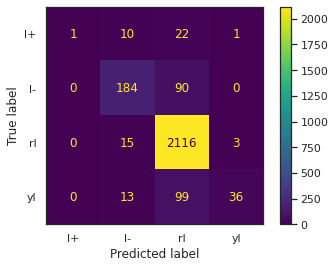

              precision    recall  f1-score   support

          l+       1.00      0.03      0.06        34
          l-       0.83      0.67      0.74       274
          rl       0.91      0.99      0.95      2134
          yl       0.90      0.24      0.38       148

    accuracy                           0.90      2590
   macro avg       0.91      0.48      0.53      2590
weighted avg       0.90      0.90      0.88      2590



In [ ]:
evaluation_metric(model_spacy_logreg, tfidf_test, target_test)

In [ ]:
print('Cross validation score:',
      cross_val_score(model_spacy_logreg, tfidf_features, y=target, cv=5, scoring='f1_macro').mean())

KeyboardInterrupt: ignored

Metric|Score
-----------------------|-----------------
Accuracy|0.90
Macro F1|0.53
Cross Validation|0.50

#### Balanced Class weights

In [ ]:
#Logistic regression model using the tfidf vectors with class weights balanced
model_spacy_logreg = LogisticRegression(solver='liblinear',
                           multi_class='ovr',
                           max_iter=100,
                           class_weight='balanced',
                           random_state=1)
model_spacy_logreg.fit(tfidf_train, target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

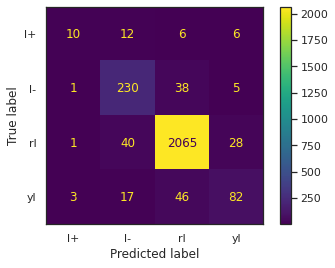

              precision    recall  f1-score   support

          l+       0.67      0.29      0.41        34
          l-       0.77      0.84      0.80       274
          rl       0.96      0.97      0.96      2134
          yl       0.68      0.55      0.61       148

    accuracy                           0.92      2590
   macro avg       0.77      0.66      0.70      2590
weighted avg       0.92      0.92      0.92      2590



In [ ]:
evaluation_metric(model_spacy_logreg, tfidf_test, target_test)

In [ ]:
print('Cross validation score:',
      cross_val_score(model_spacy_logreg, tfidf_features, y=target, cv=5, scoring='f1_macro').mean())

Cross validation score: 0.6712318335889226


Using SpaCy and TF-IDF vectorizer to process the text, the scoring for Logistic Regression are:

Metric|Score
-----------------------|-----------------
Accuracy|0.92
Macro F1|0.70
Cross Validation|0.67



#### Upsampling - SMOTE

In [ ]:
#Method to upsample training sets on each fold
imba_pipeline = make_pipeline(SMOTE(random_state=1), 
                              LogisticRegression(solver='liblinear',
                                                  multi_class='ovr',
                                                  max_iter=100,
                                                  random_state=1))

In [ ]:
imba_pipeline.fit(tfidf_train, target_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=1, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
predictions = imba_pipeline.predict(tfidf_test)

In [ ]:
print(classification_report(target_test, predictions))

              precision    recall  f1-score   support

          l+       0.50      0.35      0.41        34
          l-       0.76      0.84      0.80       274
          rl       0.97      0.94      0.96      2134
          yl       0.56      0.68      0.61       148

    accuracy                           0.91      2590
   macro avg       0.70      0.71      0.70      2590
weighted avg       0.92      0.91      0.91      2590



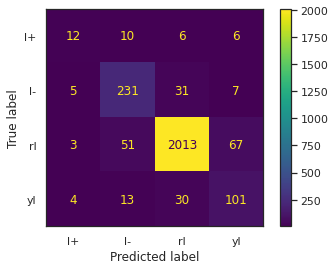

              precision    recall  f1-score   support

          l+       0.50      0.35      0.41        34
          l-       0.76      0.84      0.80       274
          rl       0.97      0.94      0.96      2134
          yl       0.56      0.68      0.61       148

    accuracy                           0.91      2590
   macro avg       0.70      0.71      0.70      2590
weighted avg       0.92      0.91      0.91      2590



In [ ]:
evaluation_metric(imba_pipeline, tfidf_test, target_test)

In [ ]:
print('Cross validation score:',
      cross_val_score(imba_pipeline, tfidf_features, y=target, scoring='f1_macro', cv=2).mean())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Cross validation score: 0.6634652078536494


Using the improved processing method and applying SMOTE to upsample the weaker class labels, we achieve:

Metric|Score
-----------------------|-----------------
Accuracy|0.91
Macro F1|0.70
Cross Validation|0.66

Overall no change to the cross validation score as the above model without upsampling.

### SVC

In [ ]:
model_svc = LinearSVC(class_weight='balanced',
                      random_state=1,
                      max_iter=1000)
model_svc.fit(tfidf_train, target_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

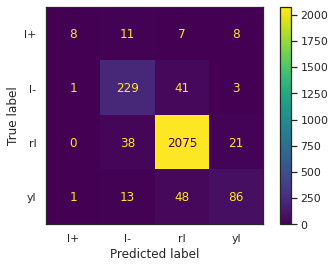

              precision    recall  f1-score   support

          l+       0.80      0.24      0.36        34
          l-       0.79      0.84      0.81       274
          rl       0.96      0.97      0.96      2134
          yl       0.73      0.58      0.65       148

    accuracy                           0.93      2590
   macro avg       0.82      0.66      0.70      2590
weighted avg       0.92      0.93      0.92      2590



In [ ]:
evaluation_metric(model_svc, tfidf_test, target_test)

In [ ]:
print('Cross validation score:',
      cross_val_score(model_svc, tfidf_features, y=target, cv=5, scoring='f1_macro').mean())

Cross validation score: 0.674267876585342


Metric|Score
-----------------------|-----------------
Accuracy|0.93
Macro F1|0.70
Cross Validation|0.67

### LightGBM

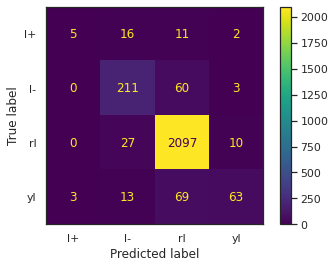

              precision    recall  f1-score   support

          l+       0.62      0.15      0.24        34
          l-       0.79      0.77      0.78       274
          rl       0.94      0.98      0.96      2134
          yl       0.81      0.43      0.56       148

    accuracy                           0.92      2590
   macro avg       0.79      0.58      0.63      2590
weighted avg       0.91      0.92      0.91      2590



In [ ]:
lgbm_model = LGBMClassifier(objective='multiclassova',
                            num_class=4,
                            class_weights='balanced',
                            random_state=1,
                            boosting_type='gbdt',
                            n_estimators=100,
                            num_leaves=31
                            )
lgbm_model.fit(tfidf_train, target_train)
evaluation_metric(lgbm_model, tfidf_test, target_test)

In [ ]:
print('Cross validation score:', cross_val_score(lgbm_model,
                tfidf_features, y=target, cv=5, scoring='f1_macro').mean())

Cross validation score: 0.6333388048376164


LGBM Classifier achieves scores lower than the Linear SVC and Logistic Regression.

Metric|Score
-----------------------|-----------------
Accuracy|0.92
Macro F1|0.63
Cross Validation|0.63

## Keras GloVe embeddings


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
zip_ref = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2021-06-25 21:38:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-25 21:38:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-25 21:38:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
keras_target = df['mark']
keras_features = df['review']

In [ ]:
le = LabelEncoder()
keras_target_le = le.fit_transform(keras_target)

In [ ]:
features_train, features_valid_temp, target_train, target_valid_temp = train_test_split(
    keras_features, keras_target_le, test_size=0.2, random_state=1, stratify=keras_target_le)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_temp, target_valid_temp, test_size=0.50, random_state=1, stratify=target_valid_temp)

In [ ]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(features_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   2, 1554, 6034,   47,    2, 9941])

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 1554, 6034, 47, 2, 9941]

In [ ]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 14497 words (5503 misses)


In [ ]:
x_train = vectorizer(np.array([[s] for s in features_train])).numpy()
x_val = vectorizer(np.array([[s] for s in features_valid])).numpy()
x_test = vectorizer(np.array([[s] for s in features_test])).numpy()

y_train = np.array(target_train)
y_val = np.array(target_valid)
y_test = np.array(target_test)

In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
preds = layers.Dense(4, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000200   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048 

In [ ]:
es = EarlyStopping(
    monitor='val_loss',
     mode='min',
      verbose=1,
       patience=5
)

mc = ModelCheckpoint(
    'best_model.h5',
     monitor='val_acc',
      mode='max',
       verbose=1,
        save_best_only=True
        )

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer='rmsprop', metrics=["acc"]
)
history = model.fit(x_train, y_train, batch_size=128, epochs=1000, validation_data=(x_val, y_val),
                    callbacks=[es, mc], class_weight=class_weights_dict)
#optimizer="rmsprop"

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/1000
324/324 [==============================] - 80s 244ms/step - loss: 1.0695 - acc: 0.6465 - val_loss: 1.0011 - val_acc: 0.5415

Epoch 00001: val_acc improved from -inf to 0.54152, saving model to best_model.h5
Epoch 2/1000
324/324 [==============================] - 78s 241ms/step - loss: 0.7464 - acc: 0.7456 - val_loss: 0.4918 - val_acc: 0.8169

Epoch 00002: val_acc improved from 0.54152 to 0.81692, saving model to best_model.h5
Epoch 3/1000
324/324 [==============================] - 78s 240ms/step - loss: 0.6287 - acc: 0.7817 - val_loss: 0.6926 - val_acc: 0.7333

Epoch 00003: val_acc did not improve from 0.81692
Epoch 4/1000
324/324 [==============================] - 78s 240ms/step - loss: 0.5230 - acc: 0.8067 - val_loss: 0.6190 - val_acc: 0.7484

Epoch 00004: val_acc did not improve from 0.81692
Epoch 5/1000
324/324 [=====================

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


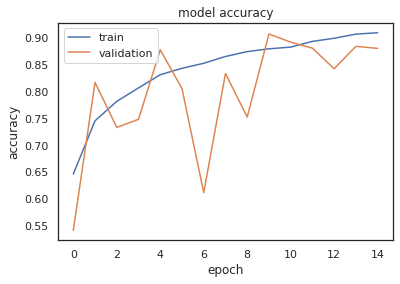

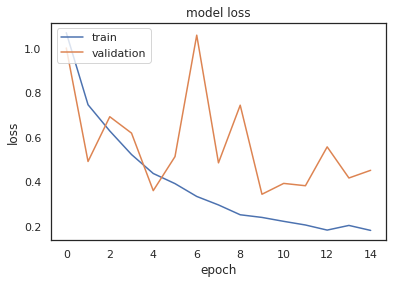

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model_best = keras.models.load_model('best_model.h5')

In [ ]:
predicts = model_best.predict(x_test)

In [ ]:
predicts_class = predicts.argmax(axis=-1)

In [ ]:
print(classification_report(
      y_test, predicts_class))

              precision    recall  f1-score   support

           0       0.46      0.36      0.40        67
           1       0.73      0.76      0.75       548
           2       0.95      0.94      0.95      4268
           3       0.51      0.57      0.54       296

    accuracy                           0.90      5179
   macro avg       0.67      0.66      0.66      5179
weighted avg       0.90      0.90      0.90      5179



rmsprop 0.4 test 0.2 dropout OR adam 0.2 test 0.2 dropout

Metric|Score
-----------------------|-----------------
Accuracy|0.91
Macro F1|0.68

rmsprop 0.1 test no dropout

Metric|Score
-----------------------|-----------------
Accuracy|0.92
Macro F1|0.70

Post BERT model the scores for this model are lower due to changes in preprocessing the text.

## Keras BERT

In [ ]:
le = LabelEncoder()
target = le.fit_transform(df_bert_model_2['mark'])
features = df_bert_model_2['review']
#target = le.fit_transform(df_bert_model['mark'])
#features = df_bert_model['review']

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(4, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#Train test split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1, stratify=target
    )

In [ ]:
max_len = 150
train_input = bert_encode(features_train, tokenizer, max_len=max_len)
test_input = bert_encode(features_test, tokenizer, max_len=max_len)

In [ ]:
num_classes=4
train_labels = keras.utils.to_categorical(target_train, num_classes)
test_labels = keras.utils.to_categorical(target_test, num_classes)

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
train_labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(target),
                                                 target)

In [ ]:
class_weights

array([19.43768769,  2.36361147,  0.30333669,  4.37052667])

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1,
    #class_weight=class_weights_dict
    )

In [ ]:
model.load_weights('/content/gdrive/My Drive/model.h5')

In [ ]:
test_pred = model.predict(test_input)

In [ ]:
test_pred

In [ ]:
test_pred_converted = test_pred.argmax(axis=-1)

In [ ]:
target_test.shape

In [ ]:
print(classification_report(
      target_test, test_pred_converted))

In [ ]:
model.save('bert_full_model')

In [ ]:
model.load('bert_full_model')

In [ ]:
!zip -r /content/bert_full_model.zip /content/bert_full_model

Running the model with both balanced and imbalanced weights, the scores didn't change.


Metric|Score
-----------------------|-----------------
Accuracy|0.96
Macro F1|0.85

# Conclusion

The NLP models used achieve similar metric scores until BERT embeddings are added.

Of the initial models, the LightGBM Classifier performed the worst having the lowest macro F1 and cross validation, whereas each other model pre BERT embeddings  is at 0.70 and 0.66/0.67 respectively.

The issue with these models is the predictive power of the weaker classes. Despite the attempts to improve this part of the model with upsampling and changing clalss weights, it would still result RL being the main predicted target. 

To fix this issue, sentiment analysis is used. The BERT Embeddings model with Keras has the best metrics score, with an accuracy and macro F1 of 0.96 and 0.85.

Text Processing Method|Model|Accuracy|Macro F1|Cross Validation
---|---|---|---|---
SpaCy/TF-IDF|Logistic Regression|0.92|0.70|0.67
Spacy/TF-IDF|Logistic Regression Upsampled|n/a|n/a|0.66
SpaCy/TF-IDF|Linear SVC|0.93|0.70|0.67
SpaCy/TF-IDF|LightGBM Classifier|0.93|0.63|0.63
GloVe/Keras TextVectorizer|Keras Deep Learning|0.92|0.70|n/a
BERT Embeddings|Keras Deep Learning|0.96|0.85|n/a

### Script for Excel

https://github.com/CalBullock/redesigned-broccoli

In [ ]:
'''Function to apply predictions to input excel file and return the output excel file'''
def excel_read_write_predictions(input_file, model, vectorizer):
  '''Read the input excel file'''
  pred_df = pd.read_excel(input_file) 

  if vectorizer == 'tfidf': #If statement for tfidf vectorizers
    temp_tfidf = pred_df['review'].apply(text_preprocessing) #Apply the tokenizer to the input reviews
    temp_tfidf = [" ".join(x) for x in temp_tfidf] #Join the tokens so they can be vectorized
    temp_vector = vectorizer.transform(temp_tfidf) #Vectorize tokens
  elif vectorizer == 'keras': #If statement for keras vectorizer
    vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
    text_ds = tf.data.Dataset.from_tensor_slices(pred_df['review']).batch(128)
    vectorizer.adapt(text_ds)

    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))

    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2
    embedding_dim = 100
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    temp_vector = vectorizer(np.array([[s] for s in pred_df['review']])).numpy()
  elif vectorizer == 'bert': #If statement for BERT vectorizer

    module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
    bert_layer = hub.KerasLayer(module_url, trainable=True)

    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

    def bert_encode(texts, tokenizer, max_len=512):
        all_tokens = []
        all_masks = []
        all_segments = []
        
        for text in texts:
            text = tokenizer.tokenize(text)
                
            text = text[:max_len-2]
            input_sequence = ["[CLS]"] + text + ["[SEP]"]
            pad_len = max_len - len(input_sequence)
            
            tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * max_len
            
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
        
        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    max_len = 150
    temp_vector = bert_encode(pred_df['review'], tokenizer, max_len=max_len)
  
  try:
      temp_proba = model.predict_proba(temp_vector)
      pred_df['prob_l+'] = temp_proba[:,0]
      pred_df['prob_l-'] = temp_proba[:,1]
      pred_df['prob_rl'] = temp_proba[:,2]
      pred_df['prob_yl'] = temp_proba[:,3]
  except:
      temp_proba = model.predict(temp_vector)
      pred_df['prob_l+'] = temp_proba[:,0]
      pred_df['prob_l-'] = temp_proba[:,1]
      pred_df['prob_rl'] = temp_proba[:,2]
      pred_df['prob_yl'] = temp_proba[:,3]
    
  
  '''Print the output'''
  print(pred_df)

  '''Export the dataframe to excel with the title'''
  return pred_df.to_excel(excel_writer='reviews_with_predictions.xlsx', index=False)

In [ ]:
test_df = pd.DataFrame()
test_df['id'] = ['1234', '2345', '3456']
test_df['review'] = ['good but it needs to be in korean', 'poorly translated', 'they did a good job with the translation']

In [ ]:
test_df.to_excel(excel_writer='test_excel.xlsx', index=False)

In [ ]:
pd.read_excel('test_excel.xlsx')

In [ ]:
excel_read_write_predictions('test_excel.xlsx', model, 'bert')

In [ ]:
pd.read_excel('reviews_with_predictions.xlsx')